In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
train =pd.read_csv("train.csv") 
test = pd.read_csv("test.csv")

In [3]:
!pip install tensorflow_decision_forests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importing the necessary libraries

In [4]:
import tensorflow_decision_forests as tfdf
try:
    from wurlitzer import sys_pipes
except:
    from colabtools.googlelog import CaptureLog as sys_pipes

from IPython.core.magic import register_line_magic
from IPython.display import Javascript

# Exploring the dataset

In [5]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [8]:
train.isnull().sum().sort_values(ascending=False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64

# Pre processing

In [9]:
train[['Transported', 'VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = train[['Transported', 'VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(value=0)

In [10]:
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep         0
Cabin           199
Destination     182
Age             179
VIP               0
RoomService     181
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            200
Transported       0
dtype: int64

In [11]:
train['Transported'] = train['Transported'].astype(int)
train['VIP'] = train['VIP'].astype(int)
train['CryoSleep'] = train['CryoSleep'].astype(int)

In [12]:
import numpy as np

# Training and evaluation

In [13]:
# Split the dataset into a training and a testing dataset.

def split_dataset(dataset, test_ratio=0.10):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]


train_ds_pd, test_ds_pd = split_dataset(train)
print("{} examples in training, {} examples for testing.".format(len(train_ds_pd), len(test_ds_pd)))

7830 examples in training, 863 examples for testing.


In [14]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label="Transported")
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label="Transported")

# Tf-df provides GradientBoosted Trees

In [15]:
# Specify the model.
model_1 = tfdf.keras.GradientBoostedTreesModel(
    num_trees=435,
    growing_strategy="BEST_FIRST_GLOBAL",
    max_depth=8,
    split_axis="AXIS_ALIGNED",
    categorical_algorithm="RANDOM",)

# Optionally, add evaluation metrics.
model_1.compile(
    metrics=["accuracy"])

# Train the model.

model_1.fit(x=train_ds, validation_data=test_ds)

Use /tmp/tmpta4v9kpg as temporary training directory
Reading training dataset...


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Training dataset read in 0:00:05.340510. Found 7830 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(863, shape=(), dtype=int32)
Validation dataset read in 0:00:00.396483. Found 863 examples.
Training model...
Model trained in 0:00:14.434278
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


# Evaluation

In [16]:
evaluation = model_1.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 664ms/step - loss: 0.0000e+00 - accuracy: 0.8158

loss: 0.0000
accuracy: 0.8158


# Inspecting model structures and hidden score

In [17]:
model_1.summary()

Model: "gradient_boosted_trees_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (13):
	Age
	Cabin
	CryoSleep
	Destination
	FoodCourt
	HomePlanet
	Name
	PassengerId
	RoomService
	ShoppingMall
	Spa
	VIP
	VRDeck

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.         "Name"  6.238127 ################
    2.  "PassengerId"  6.238127 ################
    3.      "__LABEL"  6.238127 ################
    4.          "VIP"  6.204145 ###############
    5.  "Destination"  5.447189 ##########
    6.   "HomePlanet"  5.092826 #######
    7.        "Cabin"  4.985726 ######
    8. "ShoppingMall"  4.605270 ###
    9.    "CryoSleep"  4.539284 ###
   10.    "FoodCourt"  4.429796 ##
   11.          

# Inspecting and Plotting the training logs

In [18]:
model_1.make_inspector().features()

["Age" (1; #0),
 "Cabin" (4; #1),
 "CryoSleep" (1; #2),
 "Destination" (4; #3),
 "FoodCourt" (1; #4),
 "HomePlanet" (4; #5),
 "Name" (4; #6),
 "PassengerId" (4; #7),
 "RoomService" (1; #8),
 "ShoppingMall" (1; #9),
 "Spa" (1; #10),
 "VIP" (1; #11),
 "VRDeck" (1; #12)]

In [19]:
model_1.make_inspector().variable_importances()

{'NUM_AS_ROOT': [("CryoSleep" (1; #2), 35.0),
  ("RoomService" (1; #8), 25.0),
  ("VRDeck" (1; #12), 20.0),
  ("Cabin" (4; #1), 15.0),
  ("ShoppingMall" (1; #9), 11.0),
  ("Age" (1; #0), 8.0),
  ("Spa" (1; #10), 8.0),
  ("Destination" (4; #3), 5.0),
  ("FoodCourt" (1; #4), 3.0),
  ("HomePlanet" (4; #5), 1.0)],
 'NUM_NODES': [("Age" (1; #0), 629.0),
  ("ShoppingMall" (1; #9), 558.0),
  ("FoodCourt" (1; #4), 529.0),
  ("Spa" (1; #10), 520.0),
  ("VRDeck" (1; #12), 520.0),
  ("RoomService" (1; #8), 457.0),
  ("Cabin" (4; #1), 341.0),
  ("HomePlanet" (4; #5), 163.0),
  ("Destination" (4; #3), 150.0),
  ("CryoSleep" (1; #2), 51.0),
  ("VIP" (1; #11), 11.0)],
 'SUM_SCORE': [("CryoSleep" (1; #2), 2227.6164088211863),
  ("VRDeck" (1; #12), 772.1517207566576),
  ("Spa" (1; #10), 726.3078200297155),
  ("FoodCourt" (1; #4), 613.4545831843634),
  ("RoomService" (1; #8), 503.8217052593127),
  ("HomePlanet" (4; #5), 479.5019005956783),
  ("ShoppingMall" (1; #9), 379.9864838698186),
  ("Age" (1; #0),

In [20]:
model_1.make_inspector().training_logs()

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=None, accuracy=0.7809965014457703, loss=1.3065544366836548, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=2, evaluation=Evaluation(num_examples=None, accuracy=0.7775202989578247, loss=1.2405157089233398, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=3, evaluation=Evaluation(num_examples=None, accuracy=0.7914252877235413, loss=1.1853562593460083, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=4, evaluation=Evaluation(num_examples=None, accuracy=0.7937427759170532, loss=1.1398353576660156, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=5, evaluation=Evaluation(num_examples=None, accuracy=0.7960602641105652, loss=1.0988496541976929, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=6, evaluation=Evaluation(num_examples=None, accuracy=0.7937427759170532, loss=1.0649293661117554, rmse=No

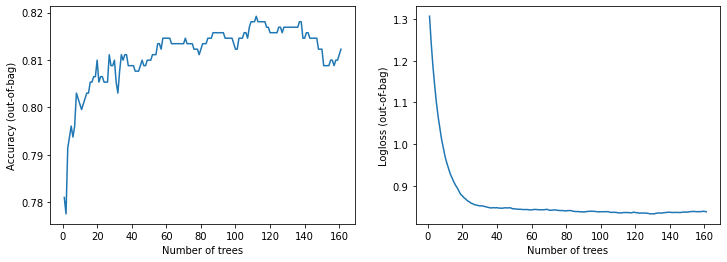

In [21]:
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

# Submission

In [22]:
updated_test = pd.read_csv('test.csv')
updated_test[['VIP', 'CryoSleep']] = updated_test[['VIP', 'CryoSleep']].fillna(value=0)
updated_test['VIP'] = updated_test['VIP'].astype(int)
updated_test['CryoSleep'] = updated_test['CryoSleep'].astype(int)
test = tfdf.keras.pd_dataframe_to_tf_dataset(updated_test)
preds = model_1.predict(test)

5/5 [==============================] - 0s 12ms/step


In [23]:
submission = pd.read_csv('sample_submission.csv')
submission['Transported'] = preds

In [24]:
preds

array([[0.6476921],
       [0.0208168],
       [0.9812617],
       ...,
       [0.9266602],
       [0.7614914],
       [0.5933805]], dtype=float32)

In [25]:
def transformTo_bool(x):
    if x < 0.4:
        return False
    else:
        return True

submission['Transported'] = submission['Transported'].apply(transformTo_bool)

print(submission)

     PassengerId  Transported
0        0013_01         True
1        0018_01        False
2        0019_01         True
3        0021_01         True
4        0023_01         True
...          ...          ...
4272     9266_02         True
4273     9269_01        False
4274     9271_01         True
4275     9273_01         True
4276     9277_01         True

[4277 rows x 2 columns]


In [26]:
sub = submission.to_csv('submission.csv', header=True, index=False)

In [27]:
sub